In [24]:
%matplotlib notebook
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.mplot3d import axes3d

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\HP\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [25]:
class Particle():
# init
    def __init__(self, r0,v0,a0,t,m,radius, Id):
        
        
        self.dt  = t[1] - t[0]
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        
        
        # Euler method

        self.r += self.dt * self.v
        self.v += self.dt * self.a
        
        
    def CheckWallLimits(self,limits,dim):
        

        for i in range(dim):   
            if self.r[i] + self.radius >= limits[i]:
                self.v[i] = - self.v[i]
                if dim == 2:
                    self.v[i] -= self.v[i] *0.1
        
            if self.r[i] - self.radius <=- limits[i]:
                self.v[i] = - self.v[i]
                if dim==2:
                    self.v[i] -= self.v[i] *0.1
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    # Getters  
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    
    
    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
               # print(self.RrVector)
    def ReduceVel(self,factor):
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
        

In [26]:
# Discretization
dt = 0.01
tmax = 30
t = np.arange(0,tmax+dt,dt)

def GetParticles(NParticles,Limit,Dim=2,dt=0.01):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.array([-15., -5.])
        v0 = np.array([1., 0.])
        a0 = np.array([0., -9.8])
        p = Particle(x0,v0,a0,t,1.,1.0,i)
        Particles_.append(p)
        
    return Particles_
Limits = np.array([20,20])

In [27]:
def RunSimulation(t,NParticles = 1):
    
    Particles = GetParticles(NParticles,Limits[0], dt=dt)
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(Limits, dim=2)
            Particles[i].Evolution(it)
        
        
    return Particles

Particles = RunSimulation(t,1)

100%|███████████████████████████████████████████████████████████████████████████| 3001/3001 [00:00<00:00, 22385.04it/s]


In [28]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        p.ReduceVel(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


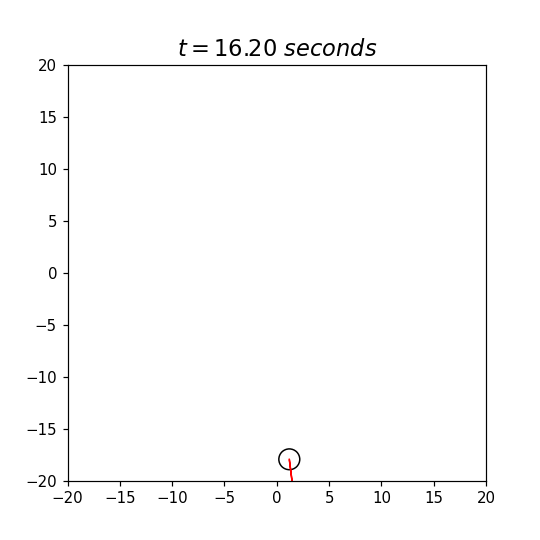

In [29]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        
        
        circle = plt.Circle( (x,y), p.GetR(), color='k', fill=False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return circle

animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

In [21]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=50, metadata=dict(artist='Me'))
animation.save('FallingBall.mp4', writer=writer_)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [30]:
def Energy(m=1):
    
    x = Particles[0].GetPositionVector()[:,0]
    y = Particles[0].GetPositionVector()[:,1]
    
    vx = Particles[0].GetVelocityVector()[:,0]
    vy = Particles[0].GetVelocityVector()[:,1]
    
    
    Ex = 0.5*m*(vx**2)
    Ey = 0.5*m*(vy**2) + m*9.8*(y+20)
    
    Et = Ex + Ey 
    
    return Et


def Potential(m=1):
    y = Particles[0].GetPositionVector()[:,1]
    U = m*9.8*(y+20)
    return U

def Kinetic(m=1):
    vx = Particles[0].GetVelocityVector()[:,0]
    vy = Particles[0].GetVelocityVector()[:,1]
    
    Kx= 0.5*m*(vx**2)
    Ky= 0.5*m*(vy**2)
    
    Kt = Kx + Ky
    return Kt

<IPython.core.display.Javascript object>


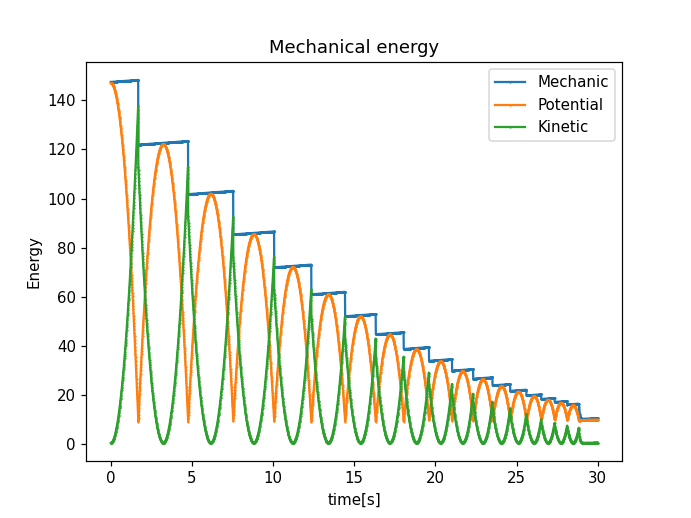

In [33]:
K = Kinetic(m=1)
U = Potential(m=1)

Em = Energy(m=1)

plt.title("Mechanical energy")
plt.xlabel("time[s]")
plt.ylabel("Energy")
plt.plot(t, Em, marker=".", markersize=1, label = "Mechanic")
plt.plot(t, U, marker = ".", markersize=1, label = "Potential")
plt.plot(t, K, marker = ".", markersize=1, label = "Kinetic")
plt.legend()
plt.show()

In [34]:
#Punto 2

dt = 0.01
tmax = 30
t = np.arange(0,tmax+dt,dt)

def GetParticles3D(NParticles,Limit,Velo,dim=3,dt=0.01):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform(-Limit+1.0, Limit-1, size = dim)
        v0 = np.random.uniform(-Velo, Velo, size=dim)
        a0 = np.zeros(dim)
        p = Particle(x0,v0,a0,t,1.,1.0,i)
        Particles_.append(p)
        
    return Particles_
Limits = np.array([10,10,10])

In [35]:
def RunSimulation3D(t,NParticles=100, Velo=10):
    
    Particles = GetParticles3D(NParticles,Limits[0],Velo = Velo,dt=dt)
    
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(Limits, dim=3)
            Particles[i].Evolution(it)
    
    return Particles

In [36]:
Particles = RunSimulation3D(t, NParticles = 100)
redt = ReduceTime(t,10)

100%|█████████████████████████████████████████████████████████████████████████████| 3001/3001 [00:11<00:00, 258.53it/s]


<IPython.core.display.Javascript object>


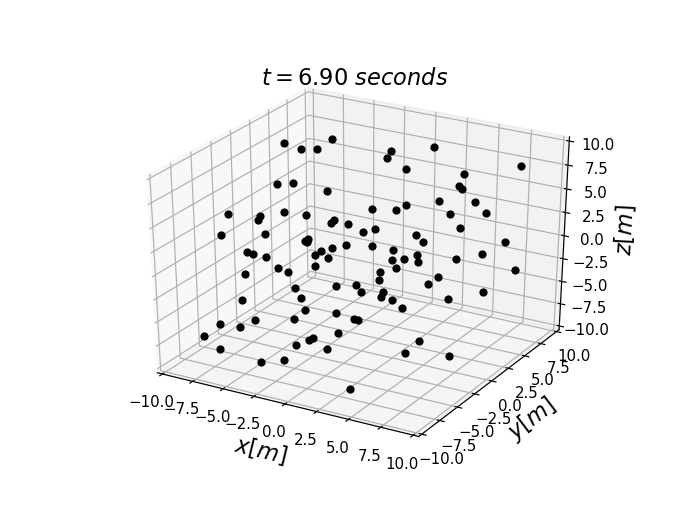

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init3D():
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(-10,10)
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
# Definimos una funcion de actualizacion

def Update3D(i):
    
    plot = ax.clear()
    init3D()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        z = p.GetRPositionVector()[i,2]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        vz = p.GetRVelocityVector()[i,2]
        
        
        plot = ax.scatter(x,y,z, c="k", marker="o")
        
        
        
    return plot
animation = anim.FuncAnimation(fig,Update3D,frames=len(redt),init_func=init)

In [ ]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=50, metadata=dict(artist='Me'))
animation.save('Box3d.mp4', writer=writer_)